**Author**: Justine Debelius (justine.debelius@ki.se)<br>
**Date**: Early winter 2022<br>
**Conda enviroment**: `micc-2020.11`<br>
**Python packages**: `pystan` (v. 2.19); `patsy` (0.5.1); <br>
**QIIME 2 version**: 2021.11<br>


This notebook was added to satisfy reviewer 1's request for something alpha diversity related.

In [3]:
import itertools as it
import os

import numpy as np
import pandas as pd
import patsy
import scipy
import skbio
import statsmodels.api as sms
import statsmodels.formula.api as smf

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sn

from qiime2 import Artifact, Metadata, Visualization

rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
# rcParams['pdf.fonttype'] = 42
np.set_printoptions(precision=5)

%matplotlib inline

In [4]:
meta_q2 = Metadata.load('data/metadata_paired.tsv')
meta = meta_q2.to_dataframe()

In [6]:
alpha_q2 = {
    fp.split('.')[0]: Artifact.load(f'data/diversity/alpha/{fp}')
    for fp in os.listdir('data/diversity/alpha')
    if ('.qza' in fp)
}

In [8]:
alpha = pd.DataFrame({
    metric: art.view(pd.Series)
    for metric, art in alpha_q2.items()
})

In [9]:
meta_alpha = pd.concat(axis=1, objs=[meta, alpha])

## Correlation

We'll start by looking at the correlation between alpha metrics within an individual.

In [107]:
alpha_pairs = meta_alpha.pivot(
    index=['long_survival', 'host_subject_id'],
    columns='tissue_num',
    values=alpha.columns,
)
corr = pd.DataFrame({
    metric: scipy.stats.spearmanr(alpha_pairs[metric][0], 
                                  alpha_pairs[metric][1])
    for metric in alpha.columns
    })
corr.rename(index={0: 'R2', 1: 'p-value'}, inplace=True)
corr = corr[['observed_features', 'shannon', 'simpson']]

So, we see a statistically signficant correlation in alpha diversity between the normal and tumor tissue samples.

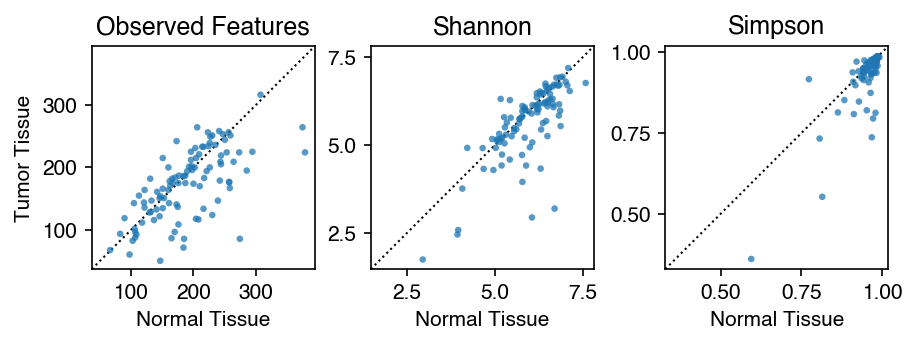

In [108]:
fig, axes = plt.subplots(1, 3, dpi=150, constrained_layout=True, 
                         figsize=(6, 2.5))
for ax, metric in zip(*(axes, corr.columns)):
    ax.scatter(alpha_pairs[metric][0], 
               alpha_pairs[metric][1], 
               s=10, 
               edgecolor='None',
               alpha=0.75)
    lims = np.vstack([ax.get_xlim(), ax.get_ylim()])
    lims = [lims.min().min(), lims.max().max()]
    ax.plot(lims, lims, 'k:', linewidth=1, zorder=0)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ticks = ax.get_xticks()
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    ax.set_xlabel('Normal Tissue')
    ax.set_ylabel('Tumor Tissue')
    ax.set_aspect(1)
    
    ax.yaxis.get_label().set_visible(metric == 'observed_features')
    ax.set_title(metric.replace('_', ' ').title())

And then we'll check the difference between the tissue types using the lme we've used other places.

In [109]:
obs_tissue = smf.mixedlm('observed_features ~ tissue_num', 
                         data=meta_alpha, 
                         groups=meta_alpha['host_subject_id']).fit()
print(obs_tissue.summary())

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: observed_features
No. Observations: 202     Method:             REML             
No. Groups:       101     Scale:              1110.0961        
Min. group size:  2       Log-Likelihood:     -1068.7730       
Max. group size:  2       Converged:          Yes              
Mean group size:  2.0                                          
----------------------------------------------------------------
              Coef.    Std.Err.    z     P>|z|   [0.025   0.975]
----------------------------------------------------------------
Intercept     190.010     5.679  33.456  0.000  178.878  201.141
tissue_num    -16.822     4.689  -3.588  0.000  -26.011   -7.632
Group Var    2147.782    16.224                                 



In [110]:
sha_tissue = smf.mixedlm('shannon ~ tissue_num', 
                         data=meta_alpha, 
                         groups=meta_alpha['host_subject_id']).fit()
print(sha_tissue.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: shannon  
No. Observations: 202     Method:             REML     
No. Groups:       101     Scale:              0.2404   
Min. group size:  2       Log-Likelihood:     -235.3654
Max. group size:  2       Converged:          Yes      
Mean group size:  2.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     5.939    0.091 65.119 0.000  5.761  6.118
tissue_num   -0.292    0.069 -4.239 0.000 -0.428 -0.157
Group Var     0.600    0.294                           



In [111]:
meta_alpha['simpson_10'] = meta_alpha['simpson'] * 10

sim_tissue = smf.mixedlm('simpson_10 ~ tissue_num', 
                         data=meta_alpha, 
                         groups=meta_alpha['host_subject_id']).fit()
print(sim_tissue.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: simpson_10
No. Observations: 202     Method:             REML      
No. Groups:       101     Scale:              0.1478    
Min. group size:  2       Log-Likelihood:     -185.5342 
Max. group size:  2       Converged:          Yes       
Mean group size:  2.0                                   
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     9.545    0.071 134.810 0.000  9.406  9.683
tissue_num   -0.188    0.054  -3.476 0.001 -0.294 -0.082
Group Var     0.359    0.225                            



In [112]:
alpha_pairs.columns.set_names(['metric', 'tissue_num'], inplace=True)
alpha_delta = alpha_pairs.T.groupby('metric').diff().T.dropna(axis=1)
alpha_delta = alpha_delta.xs(1, level='tissue_num', axis='columns')

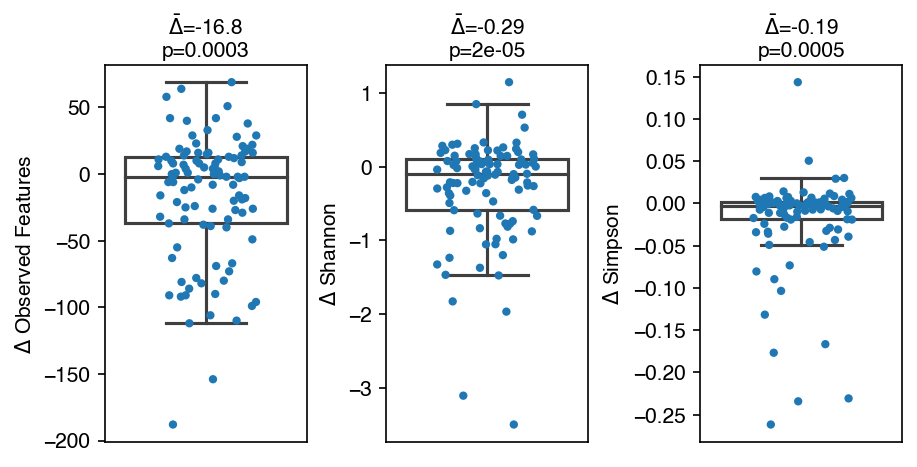

In [113]:
fig, axes = plt.subplots(1, 3, dpi=150, constrained_layout=True, figsize=(6, 3))
metrics = ['observed_features', 'shannon', 'simpson']
tissue_fits = [obs_tissue, sha_tissue, sim_tissue]
scales = [1, 2, 2]

for ax, metric, fit_, scale in zip(*(axes, metrics, tissue_fits, scales)):
    sn.boxplot(data=alpha_delta[metric],
               ax=ax,
               boxprops={'facecolor': 'w'},
               fliersize=0,
               )
    sn.stripplot(data=alpha_delta[metric],
                 ax=ax,
                 jitter=0.25,
                 edgecolor='None',
                 s=4,
                 )
    ax.set_ylabel('$\Delta$ {0}'.format(metric.replace('_', ' ').title()))
    ax.xaxis.set_tick_params(bottom=False, labelbottom=False, length=0)
    ax.set_xlabel(
        f'$\\bar{{{{\\Delta}}}}$={{0:5.{scale:1.0f}f}}\np={{1:1.0g}}'.format(
            fit_.params[1], fit_.pvalues[1]
        )
    )
    ax.xaxis.set_label_position('top')

And then we can look at the difference by survival group

In [114]:
meta_alpha['short_survival'] = (meta_alpha['long_survival'].isin([0, '0'])) * 1

In [115]:
obs_inter = smf.mixedlm('observed_features ~ tissue_num*short_survival', 
                         data=meta_alpha, 
                         groups=meta_alpha['host_subject_id']).fit()
print(obs_inter.summary())

                 Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    observed_features
No. Observations:    202        Method:                REML             
No. Groups:          101        Scale:                 1082.4277        
Min. group size:     2          Log-Likelihood:        -1060.6018       
Max. group size:     2          Converged:             Yes              
Mean group size:     2.0                                                
------------------------------------------------------------------------
                           Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------
Intercept                  185.118    8.009 23.115 0.000 169.421 200.814
tissue_num                  -8.176    6.515 -1.255 0.209 -20.946   4.593
short_survival               9.882   11.382  0.868 0.385 -12.427  32.191
tissue_num:short_survival  -17.464    9.260 -1.886 0.059 -35.613   0.

In [116]:
sha_inter = smf.mixedlm('shannon ~ tissue_num*short_survival', 
                         data=meta_alpha, 
                         groups=meta_alpha['host_subject_id']).fit()
print(sha_inter.summary())

               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     shannon  
No. Observations:      202         Method:                 REML     
No. Groups:            101         Scale:                  0.2367   
Min. group size:       2           Log-Likelihood:         -235.8192
Max. group size:       2           Converged:              Yes      
Mean group size:       2.0                                          
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  5.939    0.129 46.200 0.000  5.687  6.191
tissue_num                -0.184    0.096 -1.912 0.056 -0.373  0.005
short_survival             0.002    0.183  0.008 0.993 -0.357  0.360
tissue_num:short_survival -0.219    0.137 -1.598 0.110 -0.487  0.050
Group Var                  0.606    0.299         

In [117]:
sim_inter = smf.mixedlm('simpson_10 ~ tissue_num*short_survival', 
                         data=meta_alpha, 
                         groups=meta_alpha['host_subject_id']).fit()
print(sim_inter.summary())

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     simpson_10
No. Observations:     202         Method:                 REML      
No. Groups:           101         Scale:                  0.1481    
Min. group size:      2           Log-Likelihood:         -187.5150 
Max. group size:      2           Converged:              Yes       
Mean group size:      2.0                                           
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  9.543    0.100 95.394 0.000  9.347  9.739
tissue_num                -0.141    0.076 -1.853 0.064 -0.291  0.008
short_survival             0.004    0.142  0.027 0.978 -0.275  0.283
tissue_num:short_survival -0.095    0.108 -0.873 0.383 -0.307  0.118
Group Var                  0.362    0.228         

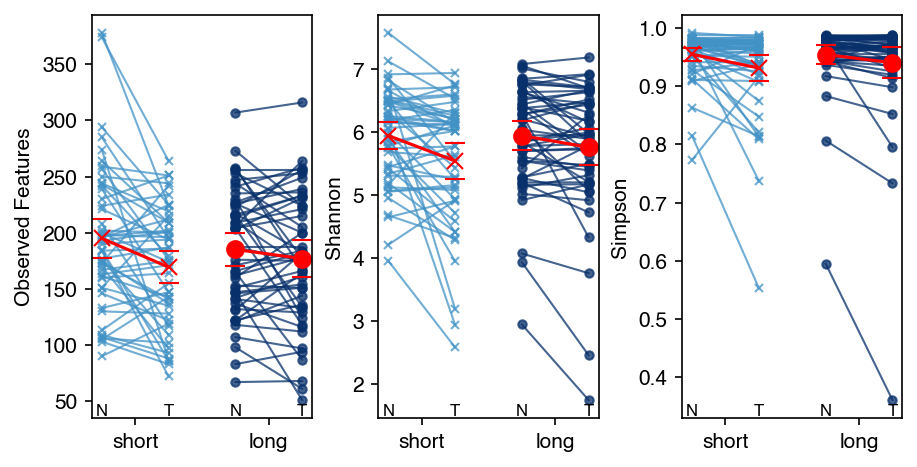

In [141]:
fig, axes = plt.subplots(1, 3, dpi=150, constrained_layout=True, figsize=(6, 3))
metrics = ['observed_features', 'shannon', 'simpson']
inter_fits = [obs_inter, sha_inter, sim_inter]
scales = [1, 2, 2]

for ax, metric, fit_, scale in zip(*(axes, metrics, inter_fits, scales)):
    ax.plot(
        np.vstack([-np.ones(50), np.ones(50)]) * 0.25 + 0, 
        alpha_pairs.loc['0', metric].T,
        marker='x',
        color='#4292c6',
        alpha=0.75,
        markersize=4,
        linewidth=1,
        )
    ax.plot(
        np.vstack([-np.ones(51), np.ones(51)]) * 0.25 + 1, 
        alpha_pairs.loc['1', metric].T,
        marker='o',
        color='#08306b',
        alpha=0.75,
        markersize=4,
        linewidth=1,
        )
    ax.errorbar(x=[-0.25, 0.25], 
                y=alpha_pairs.loc['0', metric].mean(),
                yerr=alpha_pairs.loc['0', metric].std() / np.sqrt(50) * 1.96,
                marker='x',
                color='r',
                markersize=8,
                capsize=5,
                elinewidth=0,
                )
    ax.errorbar(x=np.array([-0.25, 0.25]) + 1, 
                y=alpha_pairs.loc['1', metric].mean(),
                yerr=alpha_pairs.loc['1', metric].std() / np.sqrt(50) * 1.96,
                marker='o',
                color='r',
                markersize=8,
                capsize=5,
                elinewidth=0,
                )
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['short', 'long'])
    ax.text(-0.25, ax.get_ylim()[0], 'N', size=8, ha='center', va='bottom')
    ax.text(0.25, ax.get_ylim()[0], 'T', size=8, ha='center', va='bottom')
    ax.text(1-0.25, ax.get_ylim()[0], 'N', size=8, ha='center', va='bottom')
    ax.text(1+0.25, ax.get_ylim()[0], 'T', size=8, ha='center', va='bottom')

Finally, I think we need tumor tissue

In [146]:
tumor_alpha = \
    meta_alpha.loc[meta_alpha['tissue_num'].isin(['1', 1, '1.0'])].copy()

1108    0
1012    1
1110    0
1112    0
1014    1
       ..
1100    1
1102    1
1104    1
1006    1
1008    1
Name: short_survival, Length: 101, dtype: int64

In [149]:
model = ('short_survival ~ {metric} + age_cat + sex + ana_location + '
          'surgery_year + radical_surgery + differentiation_grade + asa_cat + '
          'stage_tnm')
obs_tumor = smf.logit(model.format(metric='observed_features'), 
                      data=tumor_alpha).fit(disp=False)
print(obs_tumor.summary())

                           Logit Regression Results                           
Dep. Variable:         short_survival   No. Observations:                  101
Model:                          Logit   Df Residuals:                       85
Method:                           MLE   Df Model:                           15
Date:                Wed, 01 Mar 2023   Pseudo R-squ.:                  0.4036
Time:                        20:16:40   Log-Likelihood:                -41.751
converged:                       True   LL-Null:                       -70.003
Covariance Type:            nonrobust   LLR p-value:                 9.960e-07
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.6024      2.366     -0.255      0.799      -5.240       4.035
age_cat[T.1.60-69]                  1.0719      1.132      0.947    

In [150]:
model = ('short_survival ~ {metric} + age_cat + sex + ana_location + '
          'surgery_year + radical_surgery + differentiation_grade + asa_cat + '
          'stage_tnm')
sha_tumor = smf.logit(model.format(metric='shannon'), 
                      data=tumor_alpha).fit(disp=False)
print(sha_tumor.summary())

                           Logit Regression Results                           
Dep. Variable:         short_survival   No. Observations:                  101
Model:                          Logit   Df Residuals:                       85
Method:                           MLE   Df Model:                           15
Date:                Wed, 01 Mar 2023   Pseudo R-squ.:                  0.4057
Time:                        20:17:08   Log-Likelihood:                -41.604
converged:                       True   LL-Null:                       -70.003
Covariance Type:            nonrobust   LLR p-value:                 8.882e-07
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           0.2513      2.721      0.092      0.926      -5.082       5.585
age_cat[T.1.60-69]                  1.0511      1.139      0.923    

In [151]:
model = ('short_survival ~ {metric} + age_cat + sex + ana_location + '
          'surgery_year + radical_surgery + differentiation_grade + asa_cat + '
          'stage_tnm')
sim_tumor = smf.logit(model.format(metric='simpson_10'), 
                      data=tumor_alpha).fit(disp=False)
print(sim_tumor.summary())

                           Logit Regression Results                           
Dep. Variable:         short_survival   No. Observations:                  101
Model:                          Logit   Df Residuals:                       85
Method:                           MLE   Df Model:                           15
Date:                Wed, 01 Mar 2023   Pseudo R-squ.:                  0.3923
Time:                        20:17:29   Log-Likelihood:                -42.539
converged:                       True   LL-Null:                       -70.003
Covariance Type:            nonrobust   LLR p-value:                 1.836e-06
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -1.1310      3.498     -0.323      0.746      -7.988       5.726
age_cat[T.1.60-69]                  0.8940      1.133      0.789    